### Preamble

In [2]:
from pathlib import Path
import os
import matplotlib as mpl

In [3]:



current_dir = Path.cwd()

target_dir = current_dir.parents[1]

os.chdir(target_dir)

print("Working directory changed to:", Path.cwd())

mpl.rcParams.update({
    "font.family": "serif",
    "font.serif": ["Times New Roman", "Times", "Nimbus Roman No9 L", "STIXGeneral"],
    "mathtext.fontset": "stix",   # math matches Times-ish
    "pdf.fonttype": 42,           # keep text as text in PDF
    "ps.fonttype": 42,
    "savefig.bbox": "tight",
    "savefig.pad_inches": 0.01,
    "figure.constrained_layout.use": True,  # don't also call tight_layout()
})

Working directory changed to: /home/hxuan/superposition


In [4]:
from src.geometry import structure_of_representation


import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import networkx as nx
from torch_geometric.utils import to_networkx
from torch_geometric.data import Data

def visualize_graph(data, one_hot=False):
    # Filter out self-loops before converting to NetworkX
    ei = data.edge_index
    edge_index_no_self_loops = ei[:, ei[0] != ei[1]]
    G = to_networkx(Data(x=data.x, edge_index=edge_index_no_self_loops, y=data.y), to_undirected=True)

    node_color = 'skyblue'
    color_map = {}
    grey_mask = None
    num_feats = 0

    if one_hot and data.x is not None and data.x.ndim == 2 and data.x.shape[1] > 0:
        num_feats = data.x.shape[1]
        _, node_colors = torch.max(data.x, dim=1)
        sum_features = torch.sum(data.x, dim=1)
        grey_mask = (sum_features == 0)
        node_colors[grey_mask] = -1  # sentinel for "no feature"
        node_color = node_colors.tolist()

        # Legend labels
        for k in range(num_feats):
            color_map[k] = f'Feature {k}'

    plt.figure(figsize=(8, 8))

    if one_hot and num_feats > 0:
        # Discrete cmap with an extra "under" color for -1
        cmap = plt.cm.get_cmap('rainbow', num_feats + 1)
        cmap.set_under('grey')
        vmin, vmax = -0.5, num_feats - 0.5

        nx.draw(
            G,
            with_labels=True,
            node_color=node_color,   # ints incl. -1
            node_size=500,
            edge_color='gray',
            cmap=cmap,
            vmin=vmin,
            vmax=vmax,
        )

        # Build legend using the SAME mapping
        norm = mcolors.Normalize(vmin=vmin, vmax=vmax)
        sm = plt.cm.ScalarMappable(norm=norm, cmap=cmap)

        handles = [
            plt.Line2D([0], [0], marker='o', color='w', label=label,
                       markerfacecolor=sm.to_rgba(k), markersize=10)
            for k, label in color_map.items()
        ]
        if grey_mask is not None and bool(grey_mask.any()):
            handles.insert(0, plt.Line2D([0], [0], marker='o', color='w',
                           label='No feature', markerfacecolor=sm.to_rgba(-1), markersize=10))
        if handles:
            plt.legend(handles=handles, title="Node Features", loc='upper right')

    else:
        # Simple non-one-hot case
        nx.draw(G, with_labels=True, node_color=node_color, node_size=500, edge_color='gray')

    plt.title("Graph Visualization")
    plt.show()



### Get model

In [17]:
from src.data import SharedDataset
from torch_geometric.loader import DataLoader
from src.experiment_superposition import ExperimentSuperposition
from src.experiment_topology import ExperimentTopology

from src.utils import CustomLogger, Constants

logger = CustomLogger(level="DEBUG")

exp = ExperimentTopology(
            hidden_dim=16,
            pooling="mean",
            lr=0.001,
            batch_size=256,
            model_type="GAT",
            seeds=[101],
            device=Constants.DEVICE,
            logger=logger
)

train_loader = DataLoader(SharedDataset.CONJUNCTION.train_data, batch_size=256, shuffle=False)
test_loader = DataLoader(SharedDataset.CONJUNCTION.test_data, batch_size=256, shuffle=False)

model = exp._create_and_fit_model(experiment_idx=0, train_loader=train_loader, use_cached_models=True)

[2025-08-18 22:15:07] [INFO] /home/hxuan/superposition/src/base_model.py:260 in fit() - Using cached model at: /home/hxuan/superposition/models/Exp2_GNN=GAT_pool=mean_s=101.pt


In [18]:
model

BaseModel(
  (criterion): BCEWithLogitsLoss()
  (convs): ModuleList(
    (0): GATv2Conv(1, 16, heads=1)
    (1-2): 2 x GATv2Conv(16, 16, heads=1)
  )
  (ffs): ModuleList(
    (0): Linear(in_features=16, out_features=2, bias=True)
  )
)

/home/hxuan/miniconda3/envs/torchgpu/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  fig.canvas.print_figure(bytes_io, **kw)


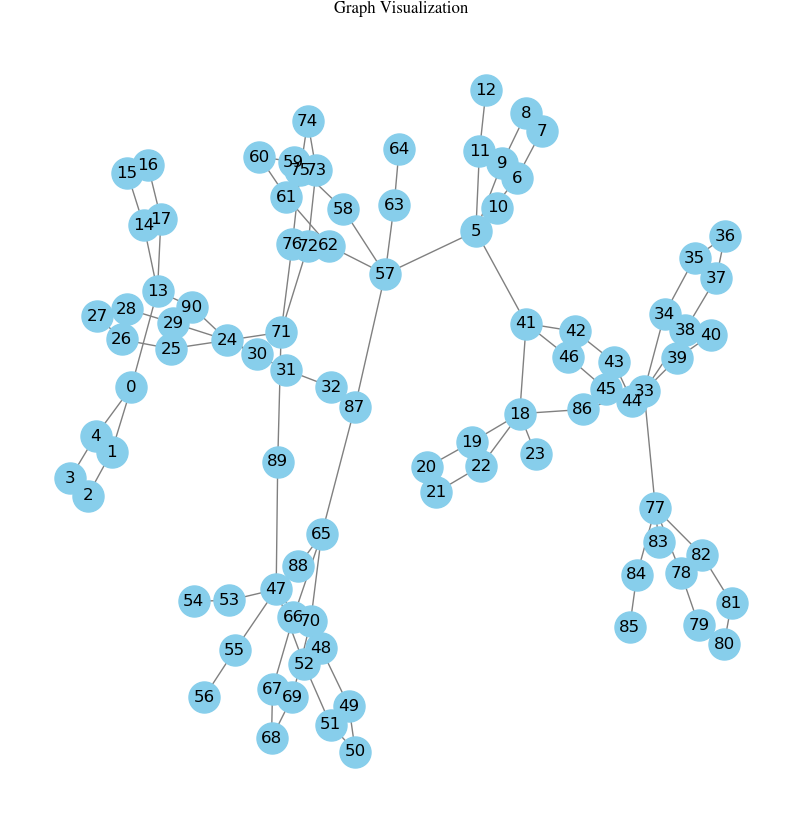

In [8]:
import torch

visualize_graph(SharedDataset.CONJUNCTION.train_data[5])

### Embeddings

In [19]:
avg_embeddings, avg_predictions, avg_loss, acc_total, prec_total, rec_total, auc_total, per_class_results = model.evaluate(test_loader)
acc_total

0.875

In [20]:
rec_total

0.9150000214576721

In [21]:
from src.features import FeatureExtractor

feature_extractor = FeatureExtractor(model)

centroids_pr, embeddings_pr, logits_pr, labels_pr, active_mask_pr = feature_extractor.compute_centroid_features(test_loader, "pr", one_hot_only=True)
centroids_gt, embeddings_gt, logits_gt, labels_gt, active_mask_gt = feature_extractor.compute_centroid_features(test_loader, "gt", one_hot_only=True)


In [22]:
from src.features import IsInsideMotifFamily, HasMotifFamily

inside_family = IsInsideMotifFamily()
has_family = HasMotifFamily(cycle_lengths=(3, 4, 5, 6))


In [23]:
all_features, _, auc, active_mask = feature_extractor.compute_node_concept_features(
    test_loader,
    concept_family=inside_family,
    layer_idx=2,
    pre_relu=False,
    auroc_thresh=0.6,
    min_pos=200,
    min_neg=200,
)

In [24]:
auc

[0.9055510701974516, 0.8036991435739096, 0.767287180658629, 0.8878794801698817]

In [25]:

all_features_g, _, auc_g, active_mask_g = feature_extractor.compute_graph_concept_features(
    test_loader,
    concept_family=has_family,
    auroc_thresh=0.6,
    min_pos=20,
    min_neg=20,
)

In [26]:
auc_g

[0.9996029986273889, 0.9149651420613517, 0.853363331729373, 0.9325337072591954]

In [27]:
from src.measure import superposition_index, wno_intrinsic

SI = superposition_index(all_features, center_cols_for_effrank=False)
SI

(1.70760763657301, 1.70760763657301, 2.342458486557007, 2.342458486557007)

In [28]:
all_features_g.shape

torch.Size([4, 16])

In [29]:
r_used, mean, mu2, WNO_r, WNO_r_raw, pc1_e = wno_intrinsic(all_features_g, remove_pc1=False, effrank_for_r_center_cols=False)
WNO_r

1.2930103242397308

In [29]:
auc_g

[0.9999985198298397, 0.9378132650781916, 0.9918252276704989, 1.0]

In [32]:
import torch
import torch.nn.functional as F


F.cosine_similarity(all_features_g, all_features_is, dim=1)

tensor([0.5913, 0.4870, 0.6567, 0.5472, 0.6959, 0.5899, 0.5496, 0.6814, 0.5427,
        0.4259, 0.5505, 0.5134, 0.5459, 0.5964, 0.6213, 0.7294],
       device='cuda:0')

In [20]:
(all_features_g * all_features_is).sum(axis=1)

tensor([ 1.2083, 12.6617, 14.4073,  5.1805,  9.4386, 10.8592,  2.0647,  6.8032,
        -3.6502,  5.7598,  3.1397, -5.6018, 21.2302,  5.4070,  4.6956,  4.2605],
       device='cuda:0')

In [49]:
from src.features import IsTypeFamily, AdjacentToFamily

is_family = IsTypeFamily(threshold=0.5)
adj_family = AdjacentToFamily(threshold=0.5, symmetrize=True, ignore_self_loops=True)

W_is, b_is, active_is, auc_is = feature_extractor.compute_node_concept_features(
    test_loader,
    concept_family=is_family,
    layer_idx=0,
    pre_relu=False,
    auroc_thresh=0.6,
    min_pos=20,
    min_neg=20,
)